<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [52]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [53]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/Users/andrewbelyaev/ML/Capstone/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [83]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))
df.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


In [84]:
df.values.tolist()[0]

['2013-11-15 08:12:07', 'fpdownload2.macromedia.com']

In [88]:
from datetime import datetime
date1 = datetime.strptime(df.timestamp[0], '%Y-%m-%d %H:%M:%S')
date2 = datetime.strptime(df.timestamp[50], '%Y-%m-%d %H:%M:%S')
delta = date2 - date1
a = []
a.append(delta.seconds)
d = pd.DataFrame()
d['new'] = a
d

,new
0,613


In [78]:
date1.hour

8

In [58]:
a = df.site.values.tolist()[3:5]
a.index(a[0])

0

In [211]:
def chunks(l, n, w = None):
    if w == None:
        w = n
    for i in range(0, len(l), w):
        yield l[i:i + n]

def get_user_id(file_name):
    temp = file_name.split(sep = '/')[-1]
    temp = temp.split(sep = '.')[0]
    temp = temp[4:]
    return temp.lstrip('0')

def create_csr_matrix(matrix):
    indptr = [0]
    indices = []
    data = []
    for row in matrix:
        for index in row:
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):
    sessions = []
    users_id = []
    num_uniq_sites = []
    sessions_timespans = []
    start_hours = []
    days_of_weeks = []
    
#     for file_name in tqdm(sorted(glob(path_to_csv_files + '/[a-z]{4}[0-9]*.csv'))):
    for file_name in tqdm(sorted(glob(path_to_csv_files + '/*'))):
        df = pd.read_csv(file_name)
        user_id = get_user_id(file_name)        
        temp_s = []
        
        for c in chunks(df["site"].values.tolist(), session_length, window_size): #parse sites
            users_id.append(user_id)
            temp_s.append(c)
            num_uniq_sites.append(len(np.unique(c)))
            
        for c in chunks(df["timestamp"].values.tolist(), session_length, window_size): #parse dates
            date1 = datetime.strptime(c[0], '%Y-%m-%d %H:%M:%S')
            date2 = datetime.strptime(c[-1], '%Y-%m-%d %H:%M:%S')
            delta = date2 - date1
            s_h = date1.hour
            d_of_w = date1.weekday()
            sessions_timespans.append(delta.seconds)
            start_hours.append(s_h)
            days_of_weeks.append(d_of_w)
            
        sessions.extend(temp_s)
    with open(site_freq_path, 'rb') as f:
        site2id = pickle.load(f)
    sessions = list(map(lambda x:
                        list(map(lambda y:
                                 site2id[y][0]
                                , x))
                       , sessions))
    sessions = list(map(lambda x:
                        x if len(x)>=session_length
                        else x + [0]*(session_length - len(x))
                       , sessions))
    df2 = pd.DataFrame(sessions, columns = ["site{}".format(i+1) for i in range(session_length)])
    df2['session_timespan'] = sessions_timespans
    df2['#unique_sites'] = num_uniq_sites
    df2['start_hour'] = start_hours 
    df2['day_of_week'] = days_of_weeks
    df2['user_id'] = users_id
    return df2

**Проверим функцию на игрушечном примере.**

In [212]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                                            session_length=10)

100%|██████████| 3/3 [00:00<00:00, 285.96it/s]


In [213]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,10,8,8,4,8,5,1,6,2,9,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,60,2,12,4,1
2,10,8,3,3,8,0,0,0,0,0,7935,3,9,4,2
3,7,5,8,5,8,5,5,6,11,7,7998,5,9,4,3
4,7,5,8,0,0,0,0,0,0,0,1471,3,12,4,3


In [214]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,10,8,8,4,8,5,1,6,2,9,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,60,2,12,4,1
2,10,8,3,3,8,0,0,0,0,0,7935,3,9,4,2
3,7,5,8,5,8,5,5,6,11,7,7998,5,9,4,3
4,7,5,8,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [215]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                                            session_length=10)

100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


CPU times: user 894 ms, sys: 33.7 ms, total: 927 ms
Wall time: 984 ms


In [216]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,33,5,8,4,31
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,284,10,8,4,31
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,258,7,8,4,31
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,30,6,8,4,31
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,6,9,8,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,4172,2426,272,140,4176,144,4172,272,143,142,27,8,15,2,241
14057,140,144,142,143,691,4172,2426,2889,2426,691,11,8,15,2,241
14058,655,2426,2889,272,140,983,2889,655,2426,2426,16,6,15,2,241
14059,2426,2426,2426,2032,983,2426,4172,4172,2889,2426,242,5,15,2,241


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [206]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                                            session_length=10)

100%|██████████| 150/150 [00:08<00:00, 17.97it/s]


CPU times: user 8.82 s, sys: 306 ms, total: 9.13 s
Wall time: 9.47 s


In [207]:
train_data_150users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,23237,23237,1329,23228,23237,1329,23237,23228,3409,11474,57,5,8,4,6
1,23228,1015,19716,3409,11474,11474,6817,11102,12303,12303,1618,8,8,4,6
2,11474,6183,23237,23237,23237,23237,11102,11474,23228,23237,2010,5,8,4,6
3,23237,23237,14144,14144,24987,14144,14144,23237,3306,23237,2006,4,9,4,6
4,23237,23237,13485,23237,14269,14267,14269,14267,6736,13485,10,5,9,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137014,15583,16826,19954,4077,15583,13621,16826,13621,15583,2966,2,6,17,0,2902
137015,1015,16826,2966,3436,14950,4077,14768,23228,23237,13621,210,10,17,0,2902
137016,13621,24278,13621,27789,15583,13169,2440,3242,5995,12242,6,9,17,0,2902
137017,22735,15583,27788,19954,15583,7132,1730,14768,13621,16826,4,9,17,0,2902


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [208]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [209]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [218]:
np.unique(train_data_10users['user_id'])

array(['100', '127', '128', '207', '237', '241', '31', '33', '39', '50'],
      dtype=object)

In [223]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
# train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)
train_data_10users['user_id'] = list(map(lambda x: id_name_dict[int(x)], train_data_10users['user_id']))
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,33,5,8,4,John
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,284,10,8,4,John
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,258,7,8,4,John
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,30,6,8,4,John
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,6,9,8,4,John


In [224]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'count of sessions')

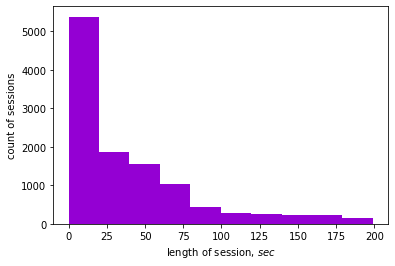

In [225]:
plt.hist(train_data_10users['session_timespan'][train_data_10users['session_timespan']<200],
         color = 'darkviolet')
plt.xlabel('length of session, $sec$')
plt.ylabel('count of sessions')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5, 0, 'count')

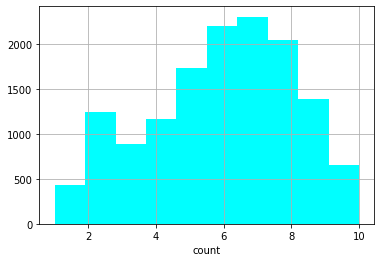

In [226]:
train_data_10users['#unique_sites'].hist(color = 'aqua')
plt.xlabel('count of unique sites')
plt.xlabel('count')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

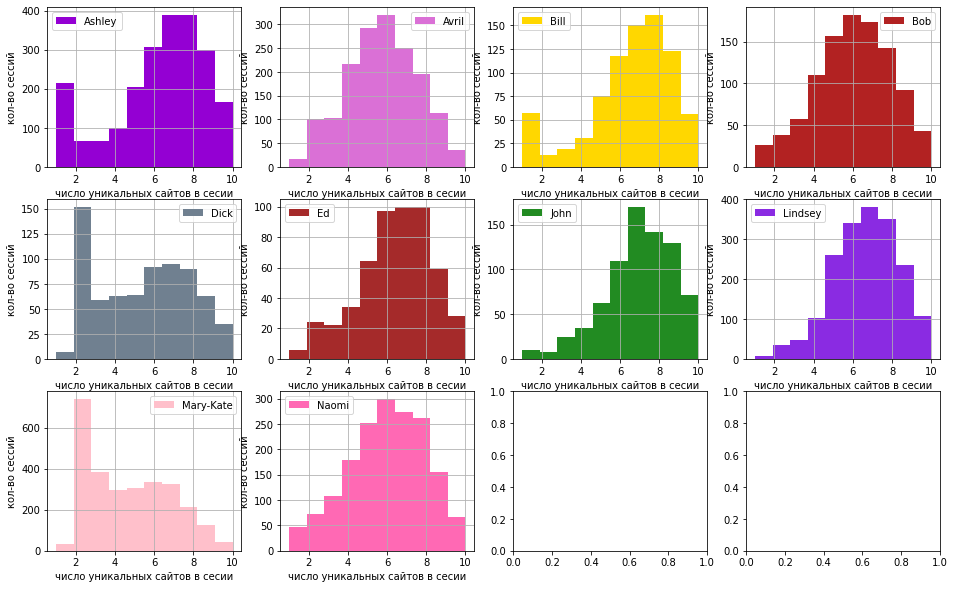

In [276]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, user in enumerate(np.unique(train_data_10users['user_id'])):
    idx_axes = (idx//axes.shape[1], idx%axes.shape[1])
    axes[idx_axes].hist(
        train_data_10users[train_data_10users.user_id == user]['#unique_sites'],
        color = color_dic[user],
        label = user)
    axes[idx_axes].legend()
    axes[idx_axes].set_xlabel('число уникальных сайтов в сесии')
    axes[idx_axes].set_ylabel('кол-во сессий')
    axes[idx_axes].grid(True)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'count of sessions')

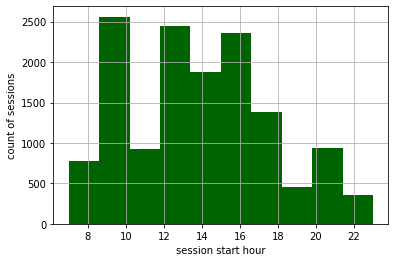

In [279]:
train_data_10users['start_hour'].hist(color = 'darkgreen')
plt.xlabel('session start hour')
plt.ylabel('count of sessions')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

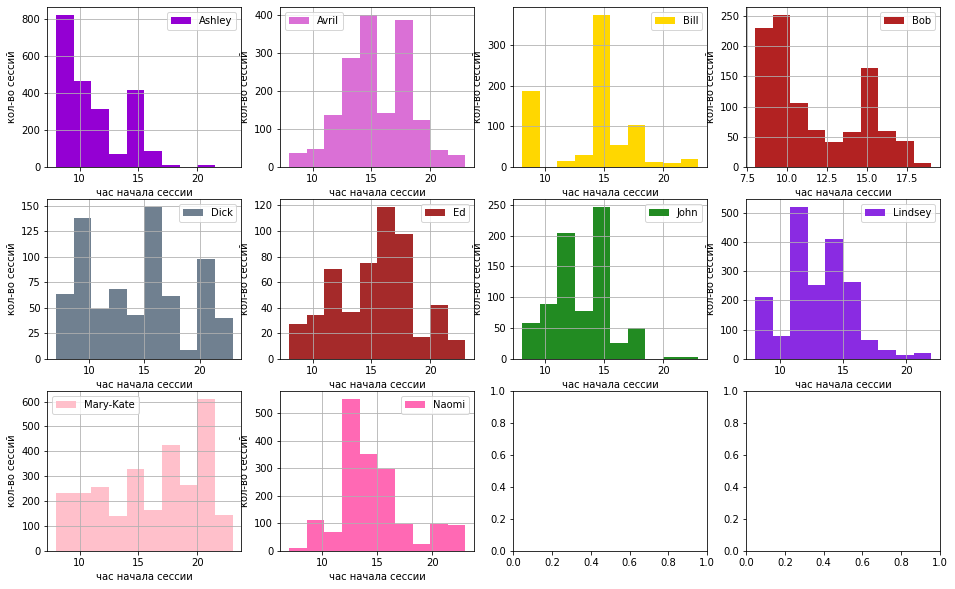

In [280]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, user in enumerate(np.unique(train_data_10users['user_id'])):
    idx_axes = (idx//axes.shape[1], idx%axes.shape[1])
    axes[idx_axes].hist(
        train_data_10users[train_data_10users.user_id == user]['start_hour'],
        color = color_dic[user],
        label = user)
    axes[idx_axes].legend()
    axes[idx_axes].set_xlabel('час начала сессии')
    axes[idx_axes].set_ylabel('кол-во сессий')
    axes[idx_axes].grid(True)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'count of sessions')

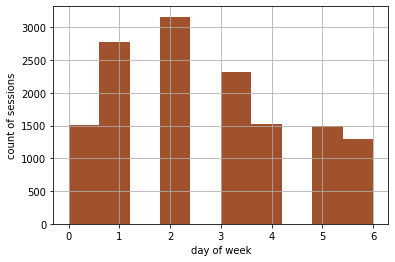

In [281]:
train_data_10users['day_of_week'].hist(color = 'sienna')
plt.xlabel('day of week')
plt.ylabel('count of sessions')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [301]:
np.unique(train_data_10users.day_of_week)

array([0, 1, 2, 3, 4, 5, 6])

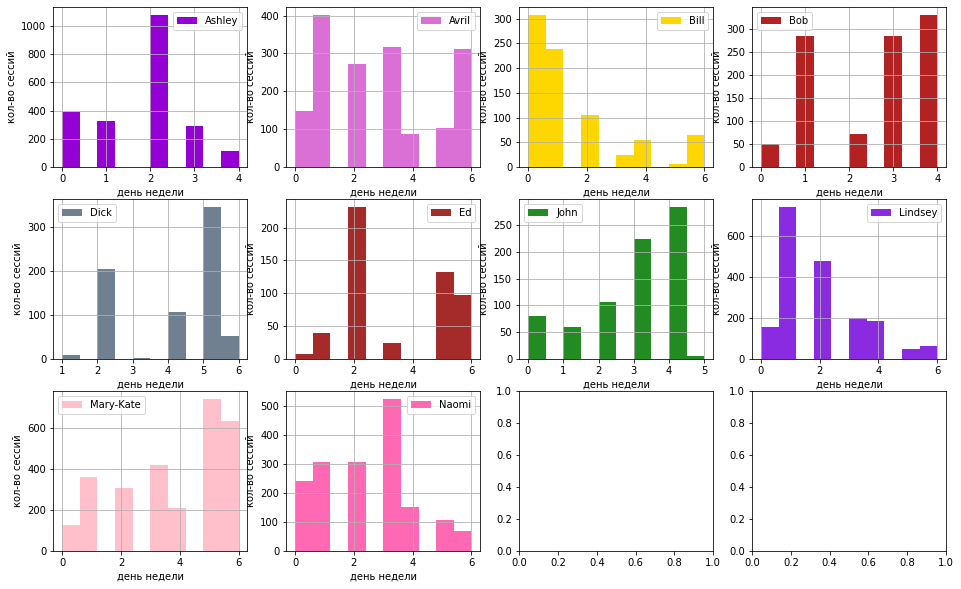

In [299]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, user in enumerate(np.unique(train_data_10users['user_id'])):
    idx_axes = (idx//axes.shape[1], idx%axes.shape[1])
    axes[idx_axes].hist(
        train_data_10users[train_data_10users.user_id == user]['day_of_week'],
        color = color_dic[user],
        label = user)
    axes[idx_axes].legend()
    axes[idx_axes].set_xlabel('день недели')
    axes[idx_axes].set_ylabel('кол-во сессий')
    axes[idx_axes].grid(True)
    axes[idx_axes].axis([0, 7, 0, 1200])
#     axes[idx_axes].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

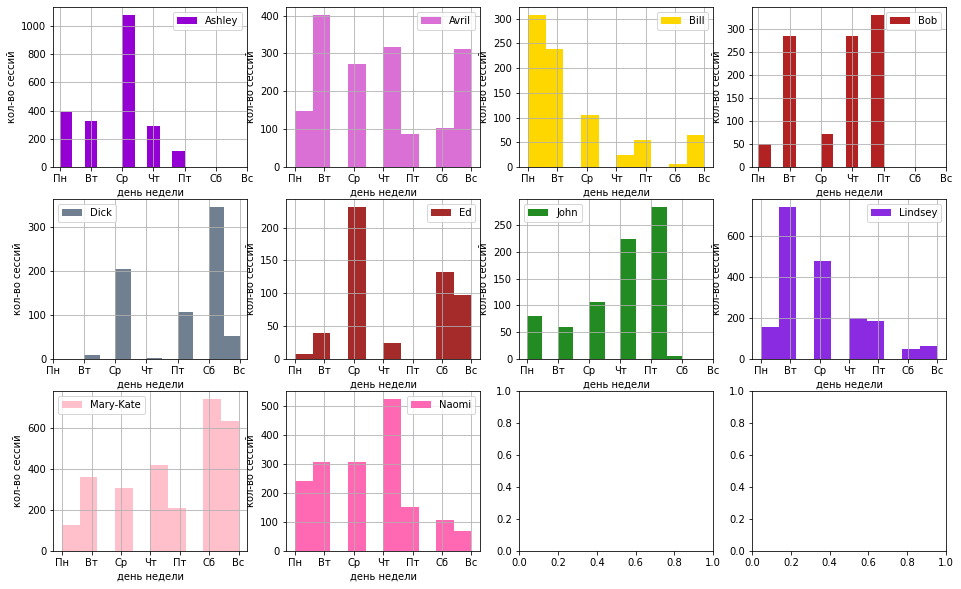

In [310]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, user in enumerate(np.unique(train_data_10users['user_id'])):
    idx_axes = (idx//axes.shape[1], idx%axes.shape[1])
    axes[idx_axes].hist(
        train_data_10users[train_data_10users.user_id == user]['day_of_week'],
        color = color_dic[user],
        label = user)
    axes[idx_axes].legend()
    axes[idx_axes].set_xlabel('день недели')
    axes[idx_axes].set_ylabel('кол-во сессий')
    axes[idx_axes].set_xticks(range(0, 7, 1))
    axes[idx_axes].grid(True)
    axes[idx_axes].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [312]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [324]:
top10_freqs = [value[1] for key, value in sorted(site_freq_10users.items(),
                                                 key = lambda x: x[1][1], reverse = True)][:10]
top10_sites = [key for key, value in sorted(site_freq_10users.items(),
                                                 key = lambda x: x[1][1], reverse = True)][:10]
print(top10_freqs)
print(top10_sites)

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

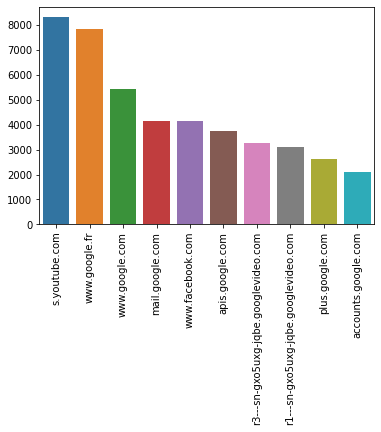

In [326]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation = 90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [328]:
np.median(train_data_10users.session_timespan)

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [330]:
np.median(train_data_10users.day_of_week)

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [331]:
np.median(train_data_150users.start_hour)

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [332]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

- частота посещения вк (vk_freq)
- индикаторы посещения топ 30 сайтов
- среднее время пребывания на сайте для каждого пользователя
- частота перехода между сайтами 
- частота посещения Facebook (facebook_freq)
- индикатор времени суток (

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [335]:
[1, 2, 3] in [2, 4, 5]

False

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def feature_engineering(current_features, path_to_csv_files, site_freq_path, features, session_length=10):
    for file_name in tqdm(sorted(glob(path_to_csv_files + '/*'))):
        df = pd.read_csv(file_name)
        avg_site_times = []

        indicator_top_30 = []
        with open(site_freq_path, 'rb') as f:
            site_freq = pickle.read(f)
        ######## индикаторы посещения топ 30 сайтов
        top_30_sites = [value[0] for key, value in sorted(site_freq.items(),
                                                 key = lambda x: x[1][1], reverse = True)][:30]
        for c in chunks(df.site.values.tolist(), session_length):
            if any(map(lambda x: x in top_30_sites, c)):
                indicator_top_30.append(1)
            else:
                indicator_top_30.append(0)
        
        avg_site_time = []
        for c in chunks(df.timestamp.values.tolist(), session_length):
            for i in range(len(c) - 1):
                date1 = datetime.strptime(c[i], '%Y-%m-%d %H:%M:%S')
                date2 = datetime.strptime(c[i+1], '%Y-%m-%d %H:%M:%S')
                delta = date2 - date1
                session_sites_delta.append(delta.seconds)
        sessions_sites_delta.append(session_sites_delta)

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 